# RECOMMENDATION SYSTEM: CONTENT BASE FILTERING

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt

In [2]:
# Load clothes description 
df = pd.read_csv('clothes_description.csv')

In [3]:
# Print the first five rows
df.head()

,id,description
0,1,"""Active classic boxers - There's a reason why ..."
1,2,"""Active sport boxer briefs - Skinning up Glory..."
2,3,"""Active sport briefs - These superbreathable n..."
3,4,"""Alpine guide pants - Skin in, climb ice, swit..."
4,5,"""Alpine wind jkt - On high ridges, steep ice a..."


- TF-IDF vectorizer calculates the TF-IDF score for each document’s description, word-by-word.
- ngram_range is the lower and upper boundary of the range of n-values for differentn-grams to be extracted. 
- All values of n such that min_n <= n <= max_n will be used. In this case we use (1,2)
- I used 'stop_words' inside the CountVectorizer because I am going to eliminate most of these common words actually may not be relevant to determining the language like 'and', 'the', 'of',... and so on.

In [4]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
#Construct the required TF-IDF matrix by fitting and transforming the data
tf_matrix = tf.fit_transform(df['description'])
tf_matrix.shape

(500, 24683)

Over 24.000 different words were used to describe the 500 clothes in this data set

In [5]:
columns = tf_matrix.columns = tf.get_feature_names()

In [6]:
#I use np.sum() to convert it directly from the sparse matrix
#This is enormously more memory-efficient because 
#it only requires one int per column since summing across columns is the total word count.
def get_freq_words(sparse_counts, columns):

    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype 
    # which we then convert into a 1-D ndarray for sorting

    word_counts = np.ravel(tf_matrix.sum(axis=0))
    freq_words = pd.Series(word_counts, index=columns).sort_values(ascending=False)

    return freq_words


freq_words = get_freq_words(tf_matrix, columns)
print(freq_words[:20])

li                   61.933024
br                   53.394952
br br                26.697476
li li                24.319483
oz                   15.371230
organic              14.794812
cotton               14.484428
organic cotton       14.164307
polyester            13.728474
ul                   13.410384
recyclable           13.045343
recycling            12.760488
threads              12.756488
common               12.756488
common threads       12.756488
program              12.743624
program br           12.718693
threads recycling    12.702558
recyclable common    12.698558
recycling program    12.689695
dtype: float64


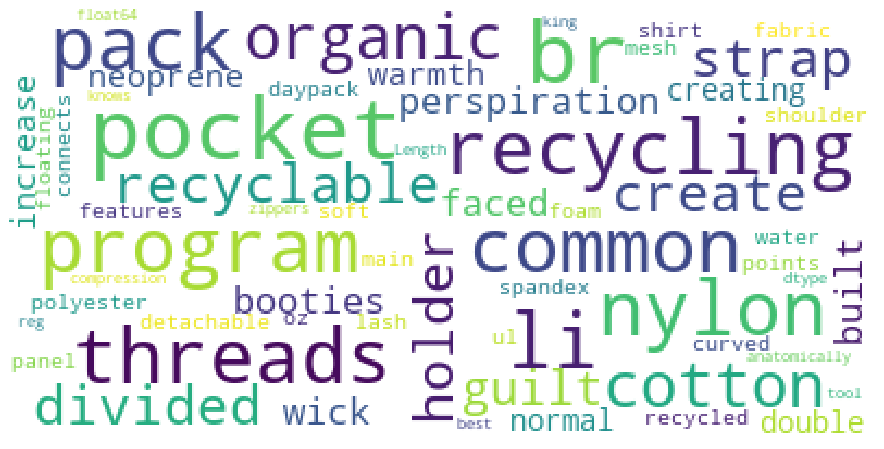

In [7]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(freq_words))

print(wordcloud)
fig = plt.figure(figsize = (18, 8),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

I can now compute a similarity score. I could use the euclidean, the Pearson and the cosine similarity scores.I will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two items. I use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate.
Since I have used the TF-IDF vectorizer, calculating the dot product will directly give me the cosine similarity score. Therefore, I will use sklearn's linear_kernel() instead of cosine_similarities() because it is faster.

In [8]:
cosine_similar = linear_kernel(tf_matrix, tf_matrix)

I’ve calculated the cosine similarity of each item with every other item in the dataset. And then arranged them according to their similarity with item i, and stored the values in a dictionary.

In [9]:
similarity = {}

for idx, row in df.iterrows():
    similar_indices = cosine_similar[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similar[idx][i], df['id'][i]) for i in similar_indices]

    similarity[row['id']] = similar_items[1:]
  

In [10]:
def item(id):
    return df.loc[df['id'] == id]['description'].tolist()[0].split(' - ')[0]

In [11]:
# Just reads the results out of the dictionary.
def get_recommendations(item_id, num):
    print("Recommending " + str(num) + " products similar to item_id " + item(item_id) + "...")
    print(" ")
    recs = similarity[item_id][:num]
   
    for rec in recs:
        print("Recommended item id: " + str(rec[1]) + item(rec[1]) + "..." + " (score:" + str(rec[0]) + ")")

get_recommendations(item_id=175, num=4)

Recommending 4 products similar to item_id 5,"Cap 2 zip neck...
 
Recommended item id: 23,"Cap 2 zip neck... (score:0.6889347579750453)
Recommended item id: 1744,"Cap 2 v-neck... (score:0.6548501863091694)
Recommended item id: 4977,"Cap 2 crew... (score:0.5731494703141836)
Recommended item id: 22,"Cap 2 t-shirt... (score:0.5657336915865767)
